In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
%matplotlib inline

#import wisps
import astropy.units as u
from astropy.coordinates import SkyCoord

import wisps
import wisps.simulations as wispsim

Adding 2404 sources from /Users/caganze/research/splat//resources/Spectra/Public/SPEX-PRISM/ to spectral database
Adding 145 sources from /Users/caganze/research/splat//resources/Spectra/Public/LRIS-RED/ to spectral database
Adding 89 sources from /Users/caganze/research/splat//resources/Spectra/Public/MAGE/ to spectral database












In [2]:
#pm.__version__

In [3]:
h=300
Rsun=83000.
Zsun=27.

In [23]:
def density_function(r, z, h=300.):
    
    """
    A custom density 
    """
    l = 2600.
    zpart=np.exp(-abs(z-27)/h)
    rpart=np.exp(-(r-8300)/l)
    return zpart*rpart

def logp(l, b, r, z, d, h):
    return np.log((d**2)*density_function(r, z, h))


def draw_with_pymc(l, b, dmax, nsample):
    
    with pm.Model() as model:
        d=pm.Uniform('d', lower=0., upper=dmax, testval=dmax/10.)
        
        x=pm.Deterministic('x',  Rsun-d*np.cos(b)*np.cos(l))
        y=pm.Deterministic('y', -d*np.cos(b)*np.sin(l))
        r=pm.Deterministic('r', (x**2+y**2)**0.5 )
        z=pm.Deterministic('z', Zsun+ d * np.sin(b))
        
        like = pm.Potential('likelihood', logp(l, b, r, z, d, h))

        trace = pm.sample(draws=int(nsample), cores=4, tune=int(nsample/20),
            discard_tuned_samples=True)
        
    return trace

def draw_with_cdf(l, b, dmax, nsample):
    d=np.logspace(0, np.log10(dmax), int(nsample))
    cdfvals=np.array([wispsim.custom_volume(l,b,0, dx, h) for dx in d])
    return wisps.random_draw(d, cdfvals/np.nanmax(cdfvals), nsample)


In [5]:
from itertools import combinations, product

In [9]:
from astropy.coordinates import SkyCoord
pnts=pd.read_pickle(wisps.OUTPUT_FILES+'/pointings_correctedf110.pkl')
#print (pnts[0].survey)
COORDS=SkyCoord([p.coord for p in pnts ])
galc=COORDS.transform_to('galactic')

LBS=np.vstack([[x.coord.galactic.l.radian,x.coord.galactic.b.radian] for x in pnts ])

LS=galc.l.radian
BS=galc.b.radian

In [29]:
tr=draw_with_pymc(LS, BS,1000, 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d]


Sampling 4 chains for 50 tune and 1_000 draw iterations (200 + 4_000 draws total) took 28 seconds.
The acceptance probability does not match the target. It is 0.9517906537602921, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.959643950292167, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9094041628112418, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9377066098080206, but should be close to 0.8. Try to increase the number of tuning steps.


In [30]:
#pm.traceplot(tr)

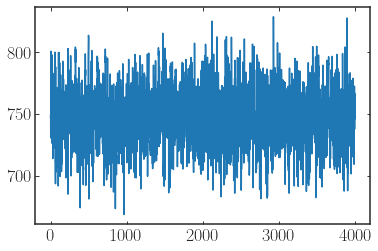

In [31]:
%matplotlib inline
fig, ax=plt.subplots()
plt.plot(tr['d'])

In [11]:

GHJK

NameError: name 'GHJK' is not defined

In [ ]:
l_values=[0, np.pi/2, np.pi, 1.5*np.pi, 2*np.pi  ]
b_values=[0, np.pi/2, np.pi]
d_values=[20, 100, 500, 1000, 3000]
s=[l_values, b_values, d_values]
nsample=int(1e3)
VALS={}
for l, b, dmax in list(product(*s)):
    pym_draws=draw_with_pymc(l, b, dmax, nsample)
    cdf_draws=(draw_with_cdf(l, b, dmax, nsample)['d']).flatten()
    
    VALS.update({'l (deg) {} b (de) {} d {} '.format(np.round(l*u.radian.to(u.degree)),
                                                      np.round(b*u.radian.to(u.degree)), dmax): 
                 {'cdf': cdf_draws, 'pymc': pym_draws}})
    

In [ ]:
%matplotlib inline
for k in VALS.keys():
    fig, ax=plt.subplots()
    plt.hist(VALS[k]['cdf'], bins=32, histtype='step', label='CDF', density=True)
    plt.hist(VALS[k]['pymc'], bins=32,histtype='step', label='PYMC',density=True)
    plt.title(k)
    plt.legend()
    plt.show()

In [ ]:
#pm.model_graph.model_to_graphviz(model)